# APT Decoder
Recibe un audio APT en WAV y lo decodifica para obtener la imagen en escala de grises.

In [19]:
# audio_APT_a_decodificar = "../APT_Tx/Files_Tx/imagen_APT_Tx.wav" # @param {type:"string"}
audio_APT_a_decodificar = "./Files_Rx/audio_APT_Rx_pyfm.wav" # @param {type:"string"}

In [20]:
# ruta al archivo de audio de entrada
in_path=audio_APT_a_decodificar

# ruta de salida a png
out_path="./Files_decoded/img_rx" # @param {type:"string"}

# límite inferior del rango dinámico, porcentaje
black_point=5 # @param {type:"number"}

# límite superior del rango dinámico, porcentaje
white_point=95 # @param {type:"number"}

In [21]:
#@markdown Librerías
from typing import List, Optional

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from PIL import Image
from scipy.io import wavfile
from scipy.signal import hilbert as transform_hilbert
from scipy.signal import resample as signal_resample

In [22]:
#@markdown Configuración

# anchura de los componentes de la imagen tras la reconstrucción
# Consultar https://www.sigidwiki.com/wiki/Automatic_Picture_Transmission_(APT)
COMPONENT_SIZES = {
    "sync_a": (0, 39),
    "space_a": (39, 86),
    "image_a": (86, 995),
    "telemetry_a": (995, 1040),
    "sync_b": (1040, 1079),
    "space_b": (1079, 1126),
    "image_b": (1126, 2035),
    "telemetry_b": (2035, 2080),
}


# secuencia de sincronización
# https://www.sigidwiki.com/wiki/Automatic_Picture_Transmission_(APT)
SYNCHRONIZATION_SEQUENCE = np.array([0, 0, 255, 255, 0, 0, 255, 255,
                                     0, 0, 255, 255, 0, 0, 255, 255,
                                     0, 0, 255, 255, 0, 0, 255, 255,
                                     0, 0, 255, 255, 0, 0, 0, 0, 0,
                                     0, 0, 0]) - 128

In [23]:
import os

def create_directory_if_not_exists(path:str):
    """
    Verificar y crear el directorio de salida si no existe
    :param path: Ruta del directorio a comprobar si existe.
    """
    try:
        directorio_salida = os.path.dirname(path)
        if not os.path.exists(directorio_salida):
            os.makedirs(directorio_salida)
            print(f"Se creó el directorio: {directorio_salida}")
    except OSError as e:
        print(f"Error al crear el directorio: {e}")


In [24]:
#@markdown Utils
def audio_to_hilbert(in_path: str, resample_rate: int = 20800) -> np.ndarray:
    """
    Carga el audio y lo convierte en información de amplitud (AM) con la transformada de Hilbert.

    :param in_path: ruta del archivo de audio, relativa o absoluta
    :param resample_rate: velocidad a la que se remuestrea el audio
    :return: información de amplitud correspondiente a la intensidad del píxel
    """

    rate, audio = wavfile.read(in_path)

    # remuestreo de audio a la velocidad adecuada (20800)
    coef = resample_rate / rate
    samples = int(coef * len(audio))
    audio = signal_resample(audio, samples)

    # si hay dos canales de audio, promediar los canales
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)

    # transformada hilbert de audio y extracción de información envolvente
    hilbert_transformed = np.abs(transform_hilbert(audio))

    return hilbert_transformed

def subsample(arr: np.ndarray, step: np.ndarray = 5) -> np.ndarray:
    """
    Muestreo de la señal transformada de Hilbert para las imágenes deseadas

    :param arr: señal tras la transformada de Hilbert
    :param step: señal tras el muestreo de los canales de interés
    :return: señal submuestreada
    """

    return signal_resample(arr, len(arr) // step)

def quantize(arr: np.ndarray, black_point: int, white_point: int) -> np.ndarray:
    """
    Digitaliza la señal a intensidades de píxel válidas en el rango uint8

    :param arr: matriz numpy de señal continua
    :param black_point: límite inferior del rango dinámico, porcentaje
    :param white_point:  límite superior del rango dinámico, porcentaje
    :return: matriz numpy cuantificada a uint8
    """

    #  porcentaje de saturación superior e inferior
    low, high = np.percentile(arr, (black_point, white_point))

    # ajuste de rango y cuantización
    arr = np.round((255 * (arr - low)) / (high - low)).clip(0, 255)
    # arr = arr.clip(0, 255)

    # pasar a 8 bits
    return arr.astype(np.uint8)

def reshape(
    arr: np.ndarray,
    synchronization_sequence: np.ndarray = SYNCHRONIZATION_SEQUENCE,
    minimum_row_separation: int = 2000,
) -> np.ndarray:
    """
    Transformar la matriz numpy en una matriz de imágenes 2D

    :param arr: matriz numpy 1D a ordenar en matriz de imágenes 2D
    :param synchronization_sequence: secuencia para indicar el inicio de fila
    :param minimum_row_separation: separación mínima entre columnas
            (un poco menos de 2080)
    :return: una matriz de imagen 2D reconstruida
    """

    # inicializar
    rows, previous_corr, previous_ind = [None], -np.inf, 0

    for current_loc in range(len(arr) - len(synchronization_sequence)):

        # inicio de fila propuesto, normalizado a cero
        row = [
            x - 128
            for x in arr[current_loc : current_loc + len(synchronization_sequence)]
        ]

        # correlación entre la fila y la secuencia de sincronización
        temp_corr = np.dot(synchronization_sequence, row)

        # si se ha pasado la separación mínima, empieza a buscar la siguiente sincronización
        if current_loc - previous_ind > minimum_row_separation:
            previous_corr, previous_ind = -np.inf, current_loc
            rows.append(arr[current_loc : current_loc + 2080])

        # si la región propuesta coincide mejor con la secuencia, actualice
        elif temp_corr > previous_corr:
            previous_corr, previous_ind = temp_corr, current_loc
            rows[-1] = arr[current_loc : current_loc + 2080]

    # apilar las filas para formar la imagen, descartar las filas incompletas al final
    return np.vstack([row for row in rows if len(row) == 2080])

def save_image(arr: np.ndarray, out_path: str) -> None:
    """
    Write numpy array to image file

    :param arr: 2D image array to write to image
    :param out_path: path to save image
    """

    image = Image.fromarray(arr.astype(np.uint8))
    create_directory_if_not_exists(out_path)
    image.save(out_path)

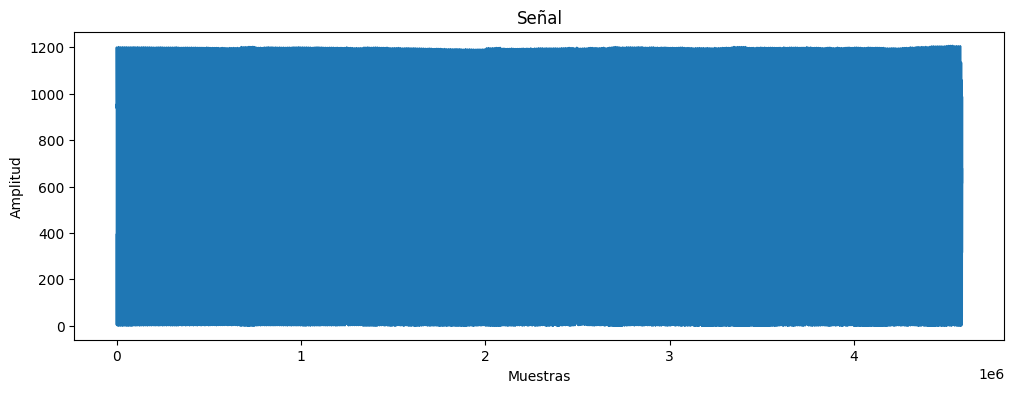

In [25]:
# Carga el audio y lo convierte en información de amplitud (AM) con la transformada de Hilbert.
decoded = audio_to_hilbert(in_path)

plt.figure(figsize=(12,4))
plt.plot(decoded)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal")
plt.show()

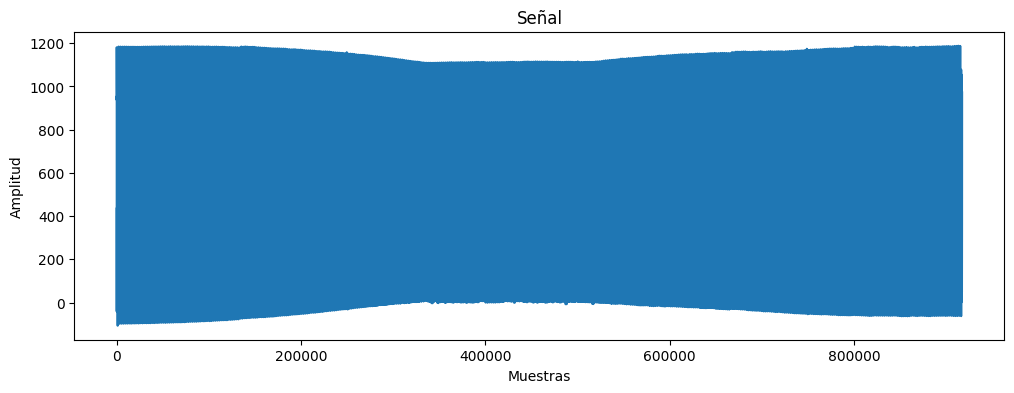

In [26]:
# Submuestreo de la señal demodulada con la transformada de Hilbert
# de millones de muestras pasa a solo cientos de miles de muestras
subsampled = subsample(decoded)

plt.figure(figsize=(12,4))
plt.plot(subsampled)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal")
plt.show()

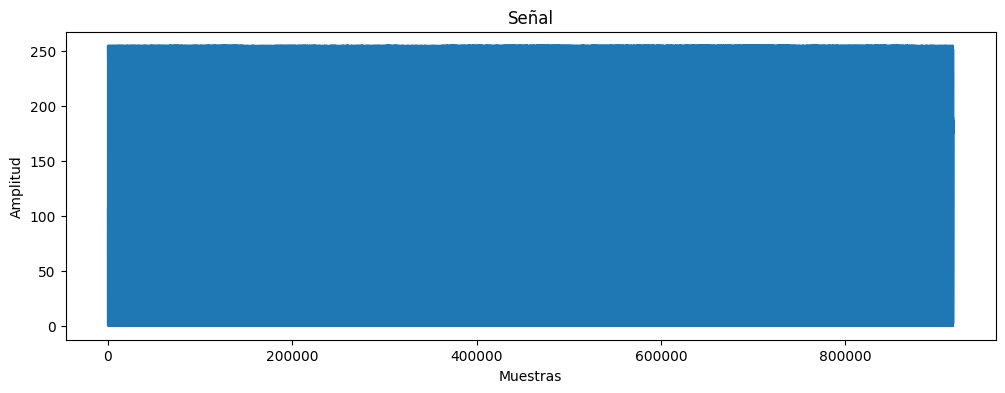

In [27]:
# Digitaliza la señal a intensidades de píxel válidas en el rango uint8
# Ahora son valores de 0 a 255
quantized = quantize(subsampled, black_point=black_point, white_point=white_point)

plt.figure(figsize=(12,4))
plt.plot(quantized)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal")
plt.show()

In [28]:
# Transformar la matriz numpy en una matriz de imágenes 2D
# Para ello encuentra el "preámbulo", que viene a ser la secuencia de sincronización.
# Debe haber una separación de 2080 píxeles entre cada secuencia de sincronización
# Es conocido que cada línea debe tener 2080 píxeles de ancho
reshaped = reshape(quantized)

In [37]:
# Invertir verticalmente según el paso del satélite
invertir = True
if invertir:
    reshaped = np.flip(reshaped, axis=0)

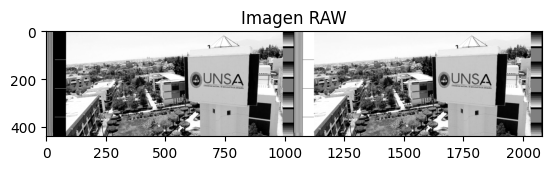

In [38]:
plt.imshow(reshaped,cmap='gray')
plt.title("Imagen RAW")
plt.show()

# Guardar matriz numpy en archivo de imagen
save_image(reshaped, out_path=f"{out_path}_raw.png")

## Filtrado de filas con ruido

In [39]:
def signal_to_noise(arr: np.ndarray, axis=0) -> np.ndarray:
    """
    Cálculo de la relación señal/ruido (SNR) (antes incluido en scipy)

    :param arr: Matriz para calcular la relación señal/ruido.
    :param axis: Eje sobre el que realizar el cálculo de SNR.
    :return: Relación señal/ruido calculada a lo largo del eje
    """

    # Media y desviación típica a lo largo del eje
    mean, standard_deviation = arr.mean(axis), arr.std(axis=axis)

    # Cálculo de SNR a lo largo del eje
    return np.where(standard_deviation == 0, 0, mean / standard_deviation)


def filter_noisy_rows(arr: np.ndarray) -> np.ndarray:
    """
    Algunos filtros basados en datos empíricos para filas con ruido

    :param arr: 2D image array
    :return: imagen con filas conn ruido filtradas
    """

    # Calcular la relación señal/ruido 
    snr = signal_to_noise(arr, axis=1)

    # Calcular la diferencia de SNR entre filas
    snr_diff = np.diff(snr, prepend=0)

    # Filtro de imagen para filas con alto SNR (ruido puro)
    # y distancia mínima en SNR entre filas
    arr = arr[(snr > 0.8) & (snr_diff < 0.05) & (snr_diff > -0.05) & (snr_diff != 0), :]

    return arr

In [40]:
# Filtra las filas con mucho ruido
denoised = filter_noisy_rows(reshaped)

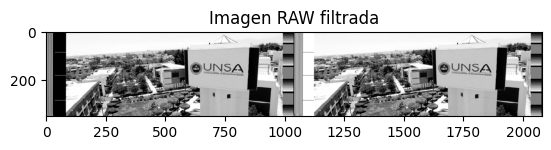

In [41]:
plt.imshow(denoised,cmap='gray')
plt.title("Imagen RAW filtrada")
plt.show()

# write numpy array to image file
save_image(denoised, out_path=f"{out_path}_raw_filtered.png")

## Guardar individualmente los componentes de la imagen

In [42]:
def select_image_components(
    arr: np.ndarray, components: Optional[List[str]]
) -> np.ndarray:
    """
    Seleccione ciertos componentes de la imagen APT y los combina como una nueva imagen.

    :param arr: Imagen como matriz 2D
    :param components: Partes de la imagen a conservar/filtrar
    :return: matriz 2D de imagen con sólo los componentes de imagen seleccionados
    """

    # Componentes de la matriz de imagen
    image_regions = []

    # Si no se selecciona componentes, retorna la imagen completa.
    if components is None:
        return arr

    # Componentes de la imagen a incluir, según la selección columna abajo
    for component in components:
        component_start, component_end = COMPONENT_SIZES[component]
        image_regions.append(arr[:, component_start:component_end])

    return np.hstack(image_regions)

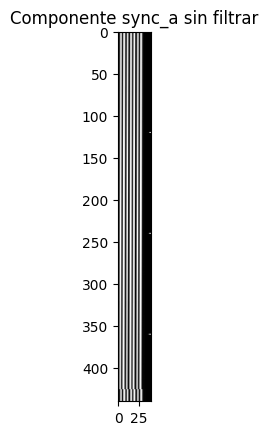

Componente de imagen guardado: sync_a


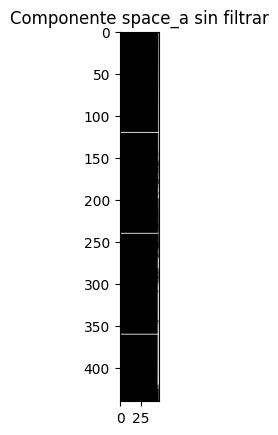

Componente de imagen guardado: space_a


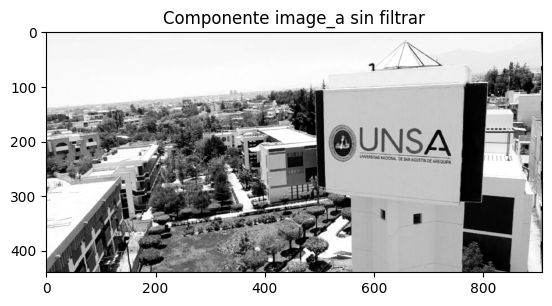

Componente de imagen guardado: image_a


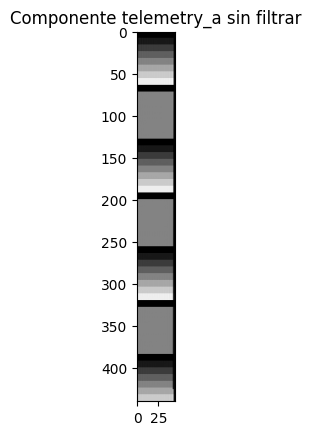

Componente de imagen guardado: telemetry_a


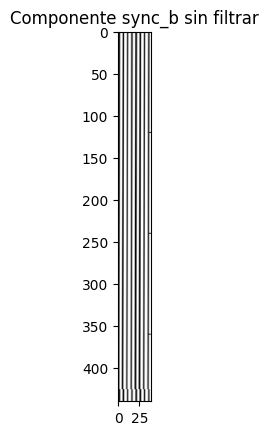

Componente de imagen guardado: sync_b


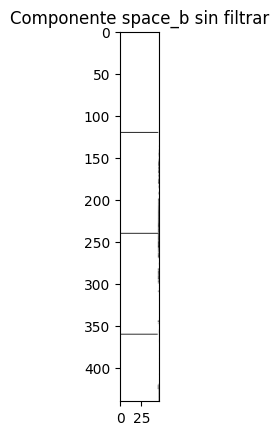

Componente de imagen guardado: space_b


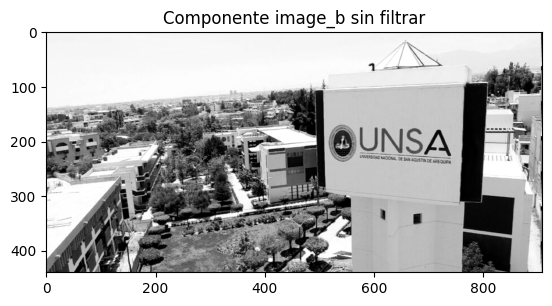

Componente de imagen guardado: image_b


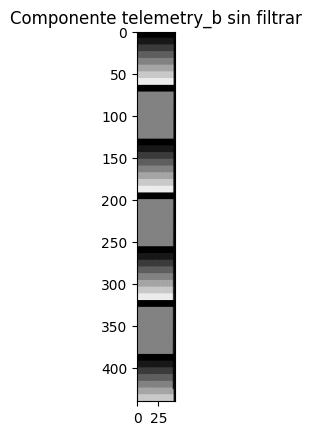

Componente de imagen guardado: telemetry_b
Componentes de imagen guardados en ./Files_decoded/img_rx


In [43]:
# Divide la imagen RAW en sus distintos componentes y los convierte
# en un diccionario donde las claves son los nombres de los 
# componentes y los valores son las imágenes correspondientes. 
image_components_nofiltered = {component: select_image_components(reshaped, [component]) for component in COMPONENT_SIZES.keys()}

# Iterar sobre el diccionario y mostrar/guardar cada imagen
for component, image_component in image_components_nofiltered.items():
    plt.imshow(image_component, cmap='gray')
    plt.title(f"Componente {component} sin filtrar")
    plt.show()

    # Guardar matriz numpy como archivo de imagen
    save_image(image_component, out_path=f"{out_path}_{component}.png")

    print(f"Componente de imagen guardado: {component}")

print(f"Componentes de imagen guardados en {out_path}")


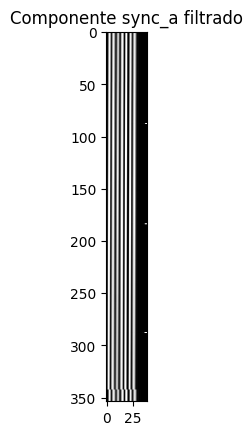

Componente de imagen filtrado guardado: sync_a


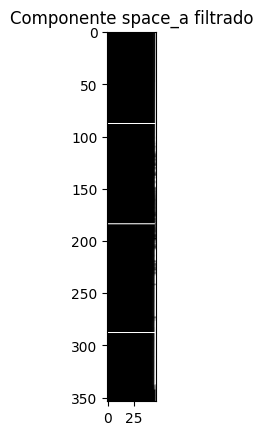

Componente de imagen filtrado guardado: space_a


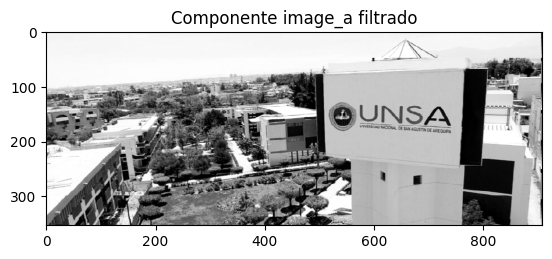

Componente de imagen filtrado guardado: image_a


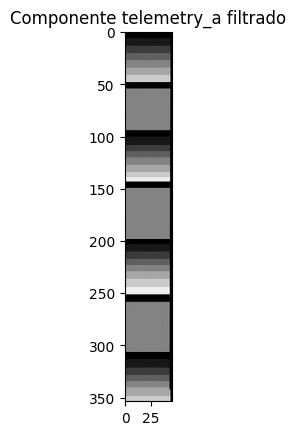

Componente de imagen filtrado guardado: telemetry_a


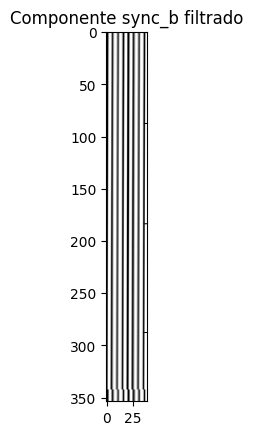

Componente de imagen filtrado guardado: sync_b


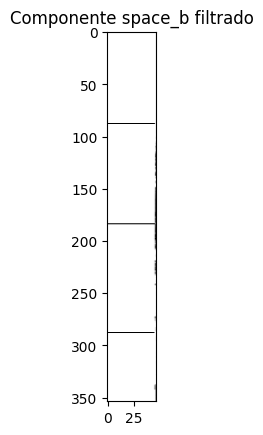

Componente de imagen filtrado guardado: space_b


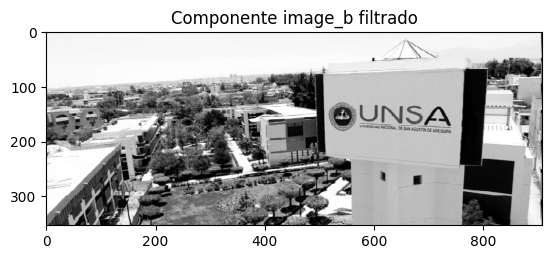

Componente de imagen filtrado guardado: image_b


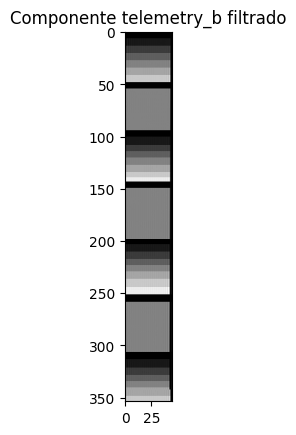

Componente de imagen filtrado guardado: telemetry_b
Componentes de imagen filtrados guardados en ./Files_decoded/img_rx


In [44]:
# Divide la imagen RAW en sus distintos componentes y los convierte
# en un diccionario donde las claves son los nombres de los 
# componentes y los valores son las imágenes correspondientes. 
image_components_filtered = {component: select_image_components(denoised, [component]) for component in COMPONENT_SIZES.keys()}

# Iterar sobre el diccionario y mostrar/guardar cada imagen
for component, image_component in image_components_filtered.items():
    plt.imshow(image_component, cmap='gray')
    plt.title(f"Componente {component} filtrado")
    plt.show()

    # Guardar matriz numpy como archivo de imagen
    save_image(image_component, out_path=f"{out_path}_{component}_filtered.png")

    print(f"Componente de imagen filtrado guardado: {component}")

print(f"Componentes de imagen filtrados guardados en {out_path}")
